In [85]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk
import seaborn as sns
import calendar

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings ("ignore")

In [5]:
df_electronics = []
for chunk in pd.read_json('/Users/olusesiamoo/Downloads/reviews_Electronics_5.json', lines=True, chunksize=10000):
    df_electronics.append(chunk)
elect_df=pd.concat(df_electronics)

In [8]:
elect_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [87]:
elect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   reviewerID      1689188 non-null  object        
 1   asin            1689188 non-null  object        
 2   reviewerName    1664458 non-null  object        
 3   helpful         1689188 non-null  object        
 4   reviewText      1689188 non-null  object        
 5   overall         1689188 non-null  int64         
 6   summary         1689188 non-null  object        
 7   unixReviewTime  1689188 non-null  int64         
 8   reviewTime      1689188 non-null  datetime64[ns]
 9   date            1689188 non-null  int64         
 10  year            1689188 non-null  int64         
 11  month           1689188 non-null  int64         
 12  day             1689188 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 167.5+ MB


In [78]:
from datetime import datetime

elect_df['reviewTime'] = pd.to_datetime(elect_df['reviewTime'], format='%m %d, %Y')


In [81]:
elect_df['year'] = elect_df['reviewTime'].dt.year
elect_df['month'] = elect_df['reviewTime'].dt.month
elect_df['day'] = elect_df['reviewTime'].dt.day

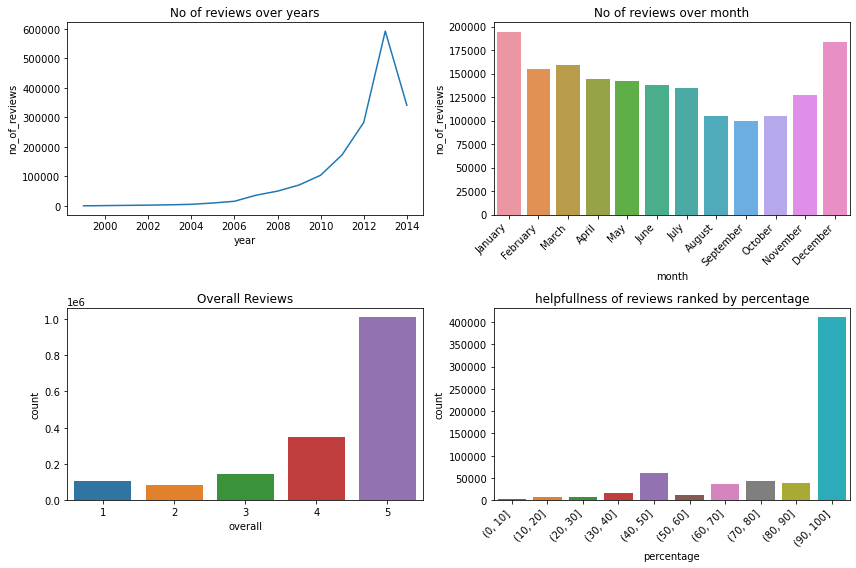

In [86]:
f, axes = plt.subplots(2,2, figsize=(12,8))
#--- Yearly Reviews
yearly = elect_df.groupby(['year'])['reviewerID'].count().reset_index()
yearly = yearly.rename(columns={'reviewerID':'no_of_reviews'})
yearChart = sns.lineplot(x='year',y='no_of_reviews',data=yearly, ax = axes[0,0])
yearChart.set_title('No of reviews over years')

#--- Monthly Reviews
monthly = elect_df.groupby(['month'])['reviewerID'].count().reset_index()
monthly['month'] = monthly['month'].apply(lambda x : calendar.month_name[x])
monthly = monthly.rename(columns={'reviewerID':'no_of_reviews'})
monthChart = sns.barplot(x='month',y='no_of_reviews',data=monthly, ax = axes[0,1])
monthChart.set_title('No of reviews over month')
monthChart.set_xticklabels(monthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

#-- Getting overall ratings for every electronics products
#Electronics['overall'].value_counts().plot(kind='bar')
sns.countplot(x = 'overall', data = elect_df, ax = axes[1,0] ).set_title('Overall Reviews')

#--- helpfulness of review.
helpfulness = elect_df[['helpful','asin']]
helpfulness[['helpfulVotes','totalVotes']] = pd.DataFrame(helpfulness.helpful.values.tolist(), index=helpfulness.index)
helpfulness = helpfulness.drop(['helpful'], axis = 1)

#--- calculating helpfulness Percentage
helpfulness['percentage'] = (helpfulness.helpfulVotes/helpfulness.totalVotes)*100
helpfulness = helpfulness.fillna(0)
final_helpfullness = helpfulness.groupby(pd.cut(helpfulness.percentage,np.arange(0,101,10))).count()
final_helpfullness = final_helpfullness.rename(columns={'percentage':'count'})
final_helpfullness = final_helpfullness.reset_index()
helpfullnessChart = sns.barplot(x='percentage',y='count',data=final_helpfullness, ax = axes[1,1])
helpfullnessChart.set_title('helpfullness of reviews ranked by percentage')
helpfullnessChart.set_xticklabels(helpfullnessChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

f.tight_layout()

In [11]:
print(elect_df.columns)
print(elect_df.shape)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
(1689188, 9)


#### Product based CF

In [12]:
count = elect_df.groupby("asin", as_index=False).count()
mean = elect_df.groupby("asin", as_index=False).mean()

electdfMerged = pd.merge(elect_df, count, how='right', on=['asin'])
electdfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013",5,5,5,5,5,5,5,5
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010",5,5,5,5,5,5,5,5
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010",5,5,5,5,5,5,5,5
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010",5,5,5,5,5,5,5,5
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011",5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",Burned these in before listening to them for a...,5,Boom -- Pop -- Pow. These deliver.,1405555200,"07 17, 2014",5,5,5,5,5,5,5,5
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",Some people like DJ style headphones or earbud...,5,"Thin and light, without compromising on sound ...",1405382400,"07 15, 2014",5,5,5,5,5,5,5,5
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",I&#8217;m a big fan of the Brainwavz S1 (actua...,5,Same form factor and durability as the S1 with...,1405555200,"07 17, 2014",5,5,5,5,5,5,5,5
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]","I've used theBrainwavz S1 In Ear Headphones, a...",5,Superb audio quality in a very comfortable set...,1405641600,"07 18, 2014",5,5,5,5,5,5,5,5


In [69]:
#rename column
electdfMerged["totalReviewers"] = electdfMerged["reviewerID_y"]
electdfMerged["overallScore"] = electdfMerged["overall_x"]
electdfMerged["summaryReview"] = electdfMerged["summary_x"]

electdfNew = electdfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]


Choosing items with reviews above 50

In [15]:
electdfMerged = electdfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = electdfMerged[electdfMerged.totalReviewers >= 100]
dfCount

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview
1339430,A3U4AFML9SZPWK,B007WTAJTO,"Leith Tussing ""I like tacos.""","[0, 0]",I bought these for my ELPH 520 more for speed ...,5,Super fast memory card,1371945600,"06 23, 2013",4915,4914,4915,4915,4915,4915,4915,4915,4915,5,Super fast memory card
1337098,AFM65NU0UXIGP,B007WTAJTO,"Ashton P. Johnson ""Zepaw""","[0, 0]",Good quality. I've been using it several devic...,5,The right microSD card,1381190400,"10 8, 2013",4915,4914,4915,4915,4915,4915,4915,4915,4915,5,The right microSD card
1337091,A2O48KBHNPDGTN,B007WTAJTO,"A. Sacremento ""car guy""","[0, 0]",Slipped perfectly into the microSD card slot o...,5,Big and Fast!,1358121600,"01 14, 2013",4915,4914,4915,4915,4915,4915,4915,4915,4915,5,Big and Fast!
1337092,A3R115ERN8N19F,B007WTAJTO,asaverio,"[0, 0]",I used this SanDisk Ultra 64 GB microSDXC Clas...,5,SanDisk Ultra 64 GB microSDXC Class 10 UHS-1 M...,1390953600,"01 29, 2014",4915,4914,4915,4915,4915,4915,4915,4915,4915,5,SanDisk Ultra 64 GB microSDXC Class 10 UHS-1 M...
1337093,A3LNSOCHROSIG8,B007WTAJTO,A. Schott,"[0, 0]",Phone missing extra storage space? This was a ...,5,Good Buy,1355184000,"12 11, 2012",4915,4914,4915,4915,4915,4915,4915,4915,4915,5,Good Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236985,A2T3KB1KHLLRI0,B000IE8Z4Q,"N. J. Manjarrez ""NJM""","[3, 3]",I don't say this about many products right out...,4,Could cost a little less but stellar for the c...,1342224000,"07 14, 2012",100,100,100,100,100,100,100,100,100,4,Could cost a little less but stellar for the c...
236984,A3BYLE1HIEAM22,B000IE8Z4Q,NewJerseyDan,"[2, 7]",I had these for a little over a year and reall...,2,Was great...while it worked.,1313712000,"08 19, 2011",100,100,100,100,100,100,100,100,100,2,Was great...while it worked.
236983,A3FZFH11J3BU7L,B000IE8Z4Q,M. Welch,"[1, 2]",Sound is amazing. The control pad is very han...,5,How can you not rate these a 5!,1263686400,"01 17, 2010",100,100,100,100,100,100,100,100,100,5,How can you not rate these a 5!
237011,A16BEKUBCKB0DK,B000IE8Z4Q,"V.T. Too ""veeteetoo""","[0, 0]",You will be dissapointed. Google USB Bose Comp...,1,Faulty USB based speakers.,1276646400,"06 16, 2010",100,100,100,100,100,100,100,100,100,1,Faulty USB based speakers.


#### Grouping all the summary Reviews by product ID

In [16]:
ProductReviewdf = elect_df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [17]:
ProductReviewdf

,asin,overall,unixReviewTime
0,0528881469,2.400000,1.310515e+09
1,0594451647,4.200000,1.396328e+09
2,0594481813,4.000000,1.382789e+09
3,0972683275,4.461187,1.354240e+09
4,1400501466,3.953488,1.352373e+09
...,...,...,...
62996,B00L21HC7A,4.578947,1.404823e+09
62997,B00L2442H0,4.882353,1.404117e+09
62998,B00L26YDA4,4.500000,1.404752e+09
62999,B00L3YHF6O,5.000000,1.405148e+09


#### Create DataFrame with specific columns

In [18]:
newdf = pd.read_csv("ProductReviewSummary.csv")
newdf = pd.merge(newdf, ProductReviewdf, on="asin", how='inner')

In [19]:
newdf = newdf[['asin', 'summaryReview', 'overall']]

#### Data Cleaning - Text tokenization

In [20]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText


In [21]:
#reset index and drop duplicate rows
newdf["summaryClean"] = newdf["summaryReview"].apply(cleanReviews)
newdf = newdf.drop_duplicates(['overall'], keep='last')
newdf = newdf.reset_index()

In [70]:
reviews = newdf["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

Reviewsdf = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
Reviewsdf = Reviewsdf.astype(int)

Reviewsdf

,adapter,advertised,affordable,air,amazing,amazon,antenna,apple,audio,awesome,...,wonderful,work,worked,working,works,worth,wow,wrong,year,years
0,0,5,0,0,1,0,0,0,0,7,...,0,3,3,0,24,1,1,0,0,0
1,0,0,0,0,1,2,0,0,0,2,...,0,2,0,0,1,0,2,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,3,1,2,25,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,2,3,1,20,0,0,1,0,0
4,0,1,0,0,0,0,1,0,0,2,...,1,1,1,0,5,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,1,1,0,0,1,1,0,0,0,1,...,0,9,1,0,28,0,0,0,0,1
2412,0,1,1,0,1,0,0,0,1,3,...,0,2,1,0,2,4,1,0,0,0
2413,1,1,0,4,1,0,2,0,0,1,...,0,4,2,0,19,0,1,0,0,0
2414,0,3,0,0,6,4,0,1,2,5,...,1,5,0,0,21,3,0,0,1,0


In [26]:
Reviewsdf.to_csv("Reviewsdf.csv")

In [27]:
# First let's create a dataset called X
X = np.array(Reviewsdf)

 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
Reviewsdf_train = X[:tsize]
Reviewsdf_test = X[tsize:]
#len of train and test
lentrain = len(Reviewsdf_train)
lentest = len(Reviewsdf_test)

In [29]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

2174
242


In [30]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(Reviewsdf_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(Reviewsdf_train)

In [31]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([Reviewsdf_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", newdf["asin"][lentrain + i] ," average rating is ",newdf["overall"][lentrain + i])
    print ("The first similar product is ", newdf["asin"][first_related_product] ," average rating is ",newdf["overall"][first_related_product])
    print ("The second similar product is ", newdf["asin"][second_related_product] ," average rating is ",newdf["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B009XE0504  average rating is  3.644230769230769
The first similar product is  B005I7KIUW  average rating is  4.30188679245283
The second similar product is  B004R2VMWC  average rating is  3.977272727272727
-----------------------------------------------------------
Based on product reviews, for  B009XNBFJK  average rating is  3.7972972972972974
The first similar product is  B0075W8E4A  average rating is  3.3653846153846154
The second similar product is  1400532655  average rating is  3.8073394495412844
-----------------------------------------------------------
Based on product reviews, for  B009YC3Y08  average rating is  4.085470085470085
The first similar product is  B007SP36ZG  average rating is  3.937984496124031
The second similar product is  B007C0Y8NQ  average rating is  3.8518518518518516
-----------------------------------------------------------
Based on product reviews, for  B009YQ8BTI  average rating is  4.526315789473684
The first similar pr

Based on product reviews, for  B00BT7RAPG  average rating is  4.372456964006259
The first similar product is  B0088LYCZC  average rating is  4.005681818181818
The second similar product is  B008AST7R6  average rating is  4.438983050847457
-----------------------------------------------------------
Based on product reviews, for  B00BUCLVZU  average rating is  4.383928571428571
The first similar product is  B006H06TVG  average rating is  4.782178217821782
The second similar product is  B004AM5RB6  average rating is  4.129310344827586
-----------------------------------------------------------
Based on product reviews, for  B00BW6KCTU  average rating is  4.725806451612903
The first similar product is  B004R7P28W  average rating is  4.472573839662447
The second similar product is  B007QOX5A0  average rating is  4.607407407407408
-----------------------------------------------------------
Based on product reviews, for  B00BW6LTG0  average rating is  3.6934306569343067
The first similar prod

Based on product reviews, for  B00DXFDHV8  average rating is  4.367521367521367
The first similar product is  B004XZL980  average rating is  4.1104651162790695
The second similar product is  B004PGMFG2  average rating is  3.6983240223463687
-----------------------------------------------------------
Based on product reviews, for  B00DY3J8VM  average rating is  3.09
The first similar product is  B001E1X67I  average rating is  3.1634615384615383
The second similar product is  B004M8RWCK  average rating is  3.5855855855855854
-----------------------------------------------------------
Based on product reviews, for  B00E055H5O  average rating is  4.600997506234414
The first similar product is  B00834SJSK  average rating is  4.566820276497696
The second similar product is  B0088PUEPK  average rating is  4.612328767123287
-----------------------------------------------------------
Based on product reviews, for  B00E0EY7Z6  average rating is  4.168498168498169
The first similar product is  B0

In [32]:
print ("Based on product reviews, for ", newdf["asin"][260] ," average rating is ",newdf["overall"][260])
print ("The first similar product is ", newdf["asin"][first_related_product] ," average rating is ",newdf["overall"][first_related_product])
print ("The second similar product is ", newdf["asin"][second_related_product] ," average rating is ",newdf["overall"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B000EXR0SI  average rating is  4.147286821705427
The first similar product is  B009SK57HY  average rating is  4.445783132530121
The second similar product is  B005TUQV0E  average rating is  4.638655462184874
-----------------------------------------------------------


### Predicting the Review Score

In [33]:
df1_train_target = newdf["overall"][:lentrain]
df1_test_target = newdf["overall"][lentrain:lentrain+lentest]
df1_train_target = df1_train_target.astype(int)
df1_test_target = df1_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(Reviewsdf_train, df1_train_target)
knnpreds_test = knnclf.predict(Reviewsdf_test)

print(classification_report(df1_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.40      0.50      0.45        34
           4       0.92      0.88      0.90       208

    accuracy                           0.83       242
   macro avg       0.66      0.69      0.67       242
weighted avg       0.84      0.83      0.83       242



#### Model Accuracy

In [34]:
print (accuracy_score(df1_test_target, knnpreds_test))

0.8264462809917356


In [35]:
print(mean_squared_error(df1_test_target, knnpreds_test))

0.17355371900826447


#### Predicting Review Score with k = 5

In [36]:
df1_train_target = newdf["overall"][:lentrain]
df1_test_target = newdf["overall"][lentrain:lentrain+lentest]
df1_train_target = df1_train_target.astype(int)
df1_test_target = df1_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(Reviewsdf_train, df1_train_target)
knnpreds_test = knnclf.predict(Reviewsdf_test)

#print (knnpreds_test)

print(classification_report(df1_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.38      0.44      0.41        34
           4       0.91      0.88      0.90       208

    accuracy                           0.82       242
   macro avg       0.65      0.66      0.65       242
weighted avg       0.83      0.82      0.83       242



In [37]:
print (accuracy_score(df1_test_target, knnpreds_test))

0.8223140495867769


In [38]:
print(mean_squared_error(df1_test_target, knnpreds_test))

0.17768595041322313


#### Predicting with k= 5, Algorithm = Brute

In [124]:
# First let's create a dataset called X
X = np.array(Reviewsdf)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(Reviewsdf)))
Reviewsdf_train = X[:tsize]
Reviewsdf_test = X[tsize:]
#len of train and test
lentrain = len(Reviewsdf_train)
lentest = len(Reviewsdf_test)

In [125]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(Reviewsdf_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(Reviewsdf_train)

In [126]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([Reviewsdf_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", newdf["asin"][lentrain + i] ," average rating is ",newdf["overall"][lentrain + i])
    print ("The first similar product is ", newdf["asin"][first_related_product] ," average rating is ",newdf["overall"][first_related_product])
    print ("The second similar product is ", newdf["asin"][second_related_product] ," average rating is ",newdf["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B009XE0504  average rating is  3.644230769230769
The first similar product is  B005I7KIUW  average rating is  4.30188679245283
The second similar product is  B004R2VMWC  average rating is  3.977272727272727
-----------------------------------------------------------
Based on product reviews, for  B009XNBFJK  average rating is  3.7972972972972974
The first similar product is  B0075W8E4A  average rating is  3.3653846153846154
The second similar product is  1400532655  average rating is  3.8073394495412844
-----------------------------------------------------------
Based on product reviews, for  B009YC3Y08  average rating is  4.085470085470085
The first similar product is  B007SP36ZG  average rating is  3.937984496124031
The second similar product is  B007C0Y8NQ  average rating is  3.8518518518518516
-----------------------------------------------------------
Based on product reviews, for  B009YQ8BTI  average rating is  4.526315789473684
The first similar pr

Based on product reviews, for  B00B1928FE  average rating is  4.444444444444445
The first similar product is  B00937CTQO  average rating is  4.133333333333334
The second similar product is  B006IHRNUY  average rating is  4.5675675675675675
-----------------------------------------------------------
Based on product reviews, for  B00B2166BS  average rating is  4.515384615384615
The first similar product is  B009UQZPA0  average rating is  4.049180327868853
The second similar product is  B004K2WZS4  average rating is  4.241935483870968
-----------------------------------------------------------
Based on product reviews, for  B00B2HH7G0  average rating is  4.640776699029126
The first similar product is  B008DWH00K  average rating is  4.377358490566038
The second similar product is  B005LN1JEC  average rating is  4.568807339449541
-----------------------------------------------------------
Based on product reviews, for  B00B46XUQU  average rating is  4.0486956521739135
The first similar pro

Based on product reviews, for  B00BWHILCY  average rating is  4.305084745762712
The first similar product is  B007C0Y8NQ  average rating is  3.8518518518518516
The second similar product is  B0054JE706  average rating is  4.131782945736434
-----------------------------------------------------------
Based on product reviews, for  B00BWL33H8  average rating is  4.239316239316239
The first similar product is  B003RRYAXQ  average rating is  4.0181818181818185
The second similar product is  B0000CE1UO  average rating is  3.839572192513369
-----------------------------------------------------------
Based on product reviews, for  B00BWLL9N8  average rating is  4.037593984962406
The first similar product is  B003MOKUIS  average rating is  4.530973451327434
The second similar product is  B003VWZE7S  average rating is  3.336206896551724
-----------------------------------------------------------
Based on product reviews, for  B00BXA7N6A  average rating is  4.502183406113537
The first similar pro

Based on product reviews, for  B00DE0EPCM  average rating is  4.5344827586206895
The first similar product is  B007LBOCVY  average rating is  4.190082644628099
The second similar product is  B009QUDLC4  average rating is  4.076388888888889
-----------------------------------------------------------
Based on product reviews, for  B00DH101WQ  average rating is  4.531531531531532
The first similar product is  B005LS2GPI  average rating is  4.842105263157895
The second similar product is  B007ZIBURC  average rating is  4.848739495798319
-----------------------------------------------------------
Based on product reviews, for  B00DHW4HXY  average rating is  4.7555555555555555
The first similar product is  B00966IREK  average rating is  4.633802816901408
The second similar product is  B004N3BH0C  average rating is  4.3125
-----------------------------------------------------------
Based on product reviews, for  B00DIFIM36  average rating is  4.052884615384615
The first similar product is  B0

Based on product reviews, for  B00F4A8FQM  average rating is  4.394230769230769
The first similar product is  B008THTOKS  average rating is  4.300884955752212
The second similar product is  B0098OCKDE  average rating is  4.12621359223301
-----------------------------------------------------------
Based on product reviews, for  B00F5NB7JK  average rating is  4.4393063583815024
The first similar product is  B005JACJ50  average rating is  4.52972972972973
The second similar product is  B002SFDJMQ  average rating is  4.201680672268908
-----------------------------------------------------------
Based on product reviews, for  B00F5NB7MW  average rating is  4.414847161572053
The first similar product is  B00426C56U  average rating is  4.147147147147147
The second similar product is  B005JACJ50  average rating is  4.52972972972973
-----------------------------------------------------------
Based on product reviews, for  B00F9FCW7K  average rating is  4.080645161290323
The first similar product

#### K = 5

In [127]:
df1_train_target = newdf["overall"][:lentrain]
df1_test_target = newdf["overall"][lentrain:lentrain+lentest]
df1_train_target = df1_train_target.astype(int)
df1_test_target = df1_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(Reviewsdf_train, df1_train_target)
knnpreds_test = knnclf.predict(Reviewsdf_test)
#print (knnpreds_test)

print(classification_report(df1_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.38      0.44      0.41        34
           4       0.91      0.88      0.90       208

    accuracy                           0.82       242
   macro avg       0.65      0.66      0.65       242
weighted avg       0.83      0.82      0.83       242



In [51]:
print (accuracy_score(df1_test_target, knnpreds_test))

0.8319559228650137


In [52]:
print(mean_squared_error(df1_test_target, knnpreds_test))

0.16804407713498623


#### kNN with k= 3 & 5, and Algorithm = KD_Tree

In [116]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(Reviewsdf_train)
distances, indices = neighbor.kneighbors(Reviewsdf_train)

In [117]:
df1_train_target = newdf["overall"][:lentrain]
df1_test_target = newdf["overall"][lentrain:lentrain+lentest]
df1_train_target = df1_train_target.astype(int)
df1_test_target = df1_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(Reviewsdf_train, df1_train_target)
knnpreds_test = knnclf.predict(Reviewsdf_test)

print(classification_report(df1_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df1_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df1_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.40      0.50      0.45        34
           4       0.92      0.88      0.90       208

    accuracy                           0.83       242
   macro avg       0.66      0.69      0.67       242
weighted avg       0.84      0.83      0.83       242

Accuracy:  0.8264462809917356
MSE:  0.17355371900826447


In [118]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(Reviewsdf_train)
distances, indices = neighbor.kneighbors(Reviewsdf_train)

In [119]:
df1_train_target = newdf["overall"][:lentrain]
df1_test_target = newdf["overall"][lentrain:lentrain+lentest]
df1_train_target = df1_train_target.astype(int)
df1_test_target = df1_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(Reviewsdf_train, df1_train_target)
knnpreds_test = knnclf.predict(Reviewsdf_test)

print(classification_report(df1_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df1_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df1_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.38      0.44      0.41        34
           4       0.91      0.88      0.90       208

    accuracy                           0.82       242
   macro avg       0.65      0.66      0.65       242
weighted avg       0.83      0.82      0.83       242

Accuracy:  0.8223140495867769
MSE:  0.17768595041322313
